In [1]:
import os
import sys

import numpy as np
import pandas as pd

from scipy.stats import linregress
from scipy.stats import gaussian_kde
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import seaborn as sns

import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#Personal functions
sys.path.append('../scripts')

from other_functions import create_earth_grid, get_cell_coordinates, get_mainshock
from plot_data import custom_marker_size

In [2]:
current_directory = os.getcwd()
clusters_folder_path = os.path.join(current_directory,'../ressources/clusters')
clusters_filename = 'clusters_dataset.csv'
cluster_file_path = os.path.join(clusters_folder_path,clusters_filename)
grid, step = create_earth_grid(power_scale = 4, step_num = 7)
    
mag_threshold = 3.5
max_mag = 9.1

threshold_year = 1995

In [3]:
def years_since_threshold(threshold_year):
    reference_date = datetime(threshold_year, 1, 1)
    current_date = datetime.now()
    days_difference = (current_date - reference_date).days
    years_difference = days_difference / 365.25

    return years_difference

    Aftershocks can mostly be apparented to exponential distribution


    https://www.mdpi.com/2076-3417/12/4/1809#B44-applsci-12-01809 :
    Reasenberg and Jones [8] were one of the first in developing an aftershock forecasting model. They introduced a parametric model that was capable of computing the probabilities of aftershocks in a certain time window after a mainshock for California. Michael et al. [9] proposed the methodology which aforementioned model parameters can be estimated with Bayesian updating from both the ongoing aftershock sequence and from historic aftershock sequences.

In [4]:
clusters_df = pd.read_csv(cluster_file_path)
clusters_df.head(5)

MC_lab  SC_lab ST_lab   grid_cell          id                      time  \
0       0       0      1  (281, 622)  usp00076a0  1995-11-04T20:07:39.890Z   
1       0       0      1  (280, 622)  usp00076bd  1995-11-05T17:14:53.680Z   
2       0       0     15  (280, 625)  usp00098zq  1999-05-29T20:10:45.250Z   
3       0       0     16  (279, 623)  usp0009ks9  2000-01-05T09:45:18.710Z   
4       0       0     16  (279, 623)  usp0009ksf  2000-01-05T13:08:17.760Z   

   latitude  longitude  depth  mag nearest_area  delta_days  delta_dist  \
0    33.018     92.140   33.0  4.0        China   -0.880021   14.727690   
1    32.896     92.201   24.4  5.1        China    0.000000    0.000000   
2    32.892     93.771   33.0  5.4        China    0.000000    0.000000   
3    32.222     92.700   33.0  5.5        China    0.000000    0.000000   
4    32.224     92.859   33.0  3.9        China    0.140961   14.975228   

   delta_depth  delta_mag  
0         -8.6        1.1  
1          0.0        0.0  
2          0.0        0.0  
3          0.0        0.0  
4          0.0        1.6

In [5]:
clusters_data_MAS = clusters_df[clusters_df['delta_days']>=0.].groupby(['MC_lab','SC_lab','ST_lab']) #WITHOUT FORESHOCKS : Main After Shocks

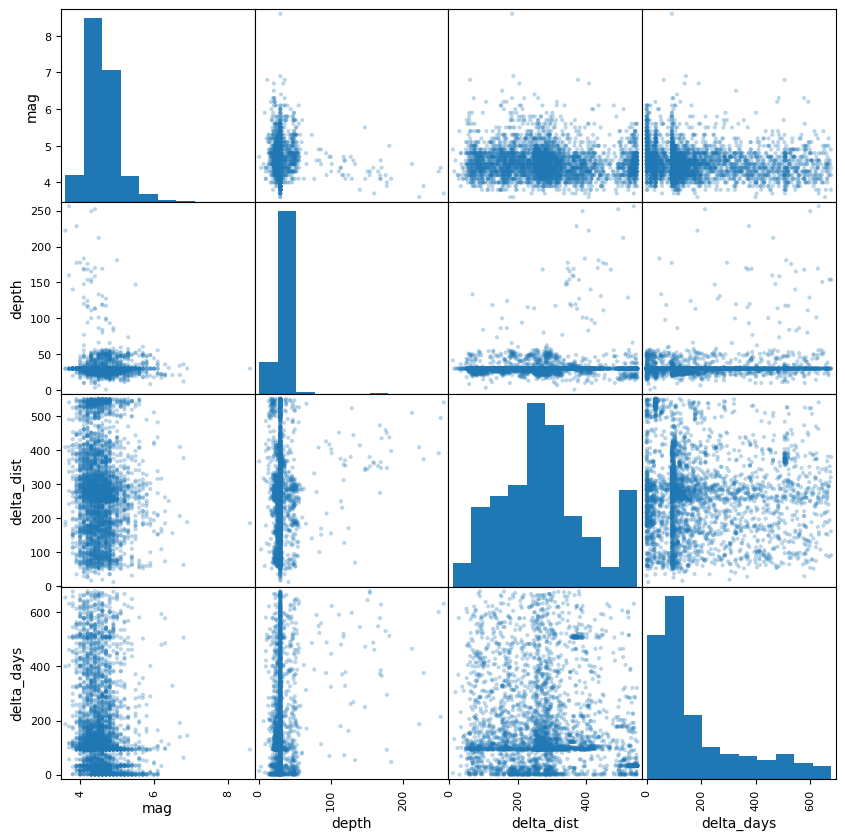

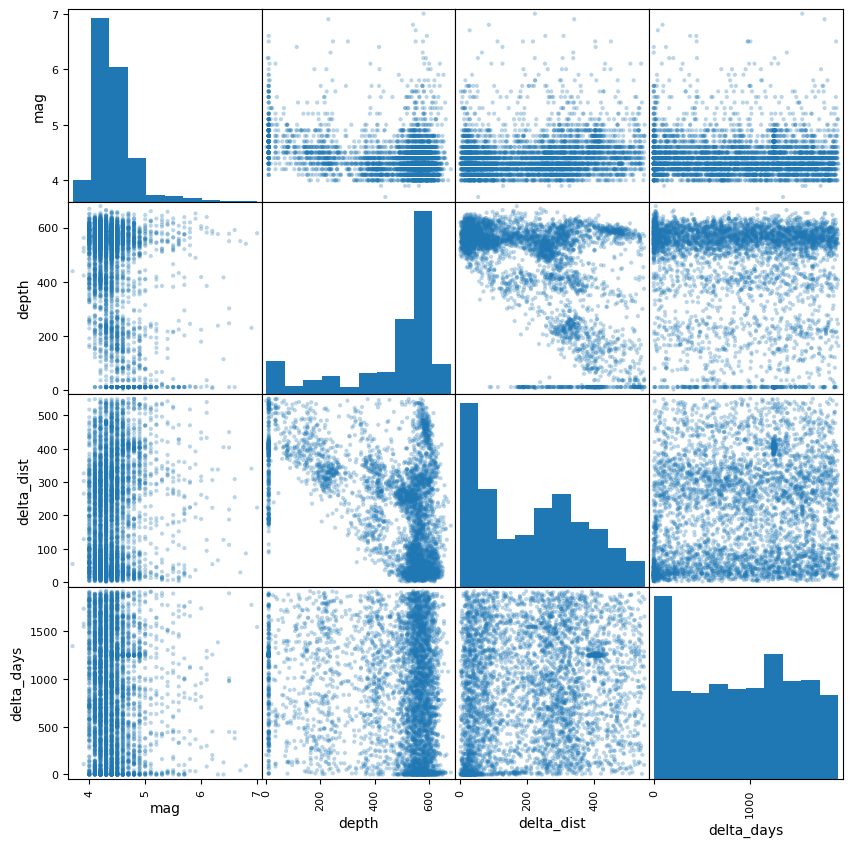

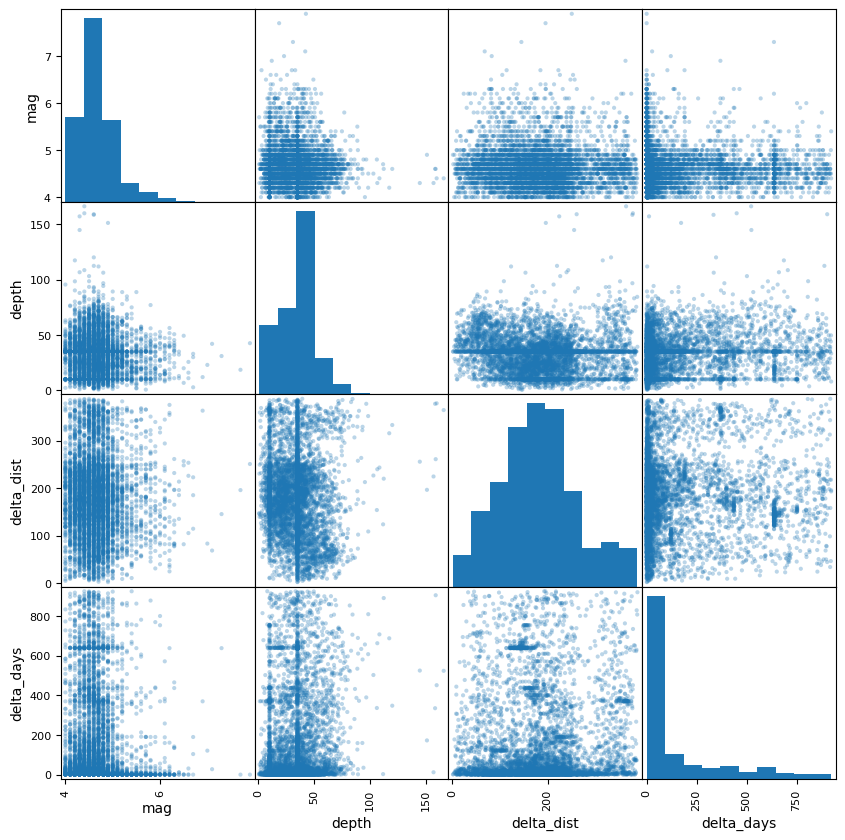

In [6]:
selected_columns = ['mag','depth','delta_dist','delta_days']
for cluster_label, cluster_data in clusters_data_MAS:
    if len(cluster_data)>1:
        mainshock = get_mainshock(cluster_data).copy()
        MS_idx = cluster_data.mag.idxmax()
        foreshocks = cluster_data.loc[:MS_idx]
        aftershocks = cluster_data.loc[MS_idx+1:]
        
        #we look the possible correlations in the clusters (we only plot the biggest ones...)
        if len(aftershocks)>=3500:
            pd.plotting.scatter_matrix(aftershocks[selected_columns], alpha=0.3, figsize=(10, 10))

(0, 107, '86')


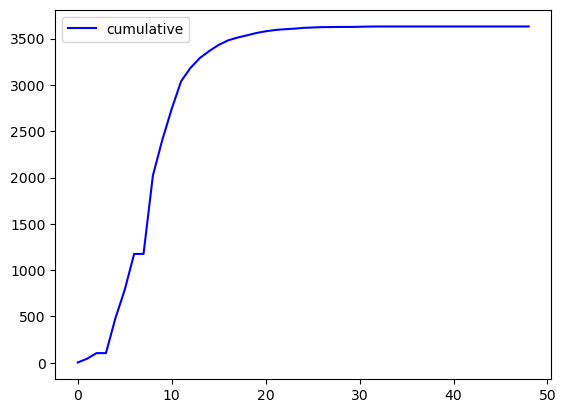

(0, 118, '28')


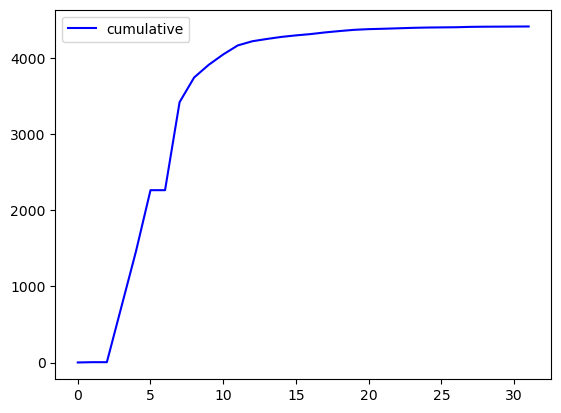

(0, 138, '128')


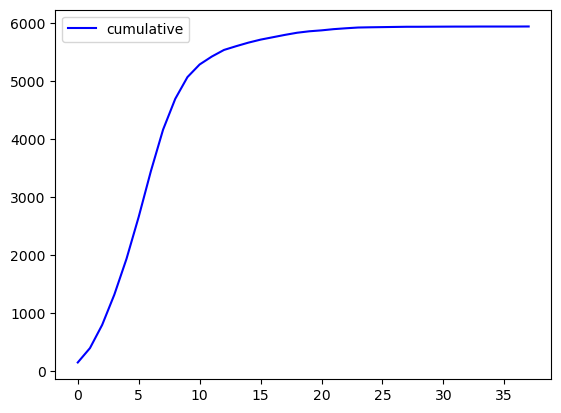

(array([ 0.,  0.,  0.,  2., 27.]), 18968)

In [7]:
aftershock_sizes = []
for cluster_label, cluster_data in clusters_data_MAS:
    # if len(cluster_data)>1:
        mainshock = get_mainshock(cluster_data).copy()
        MS_idx = cluster_data.mag.idxmax()
        foreshocks = cluster_data.loc[:MS_idx]
        aftershocks = cluster_data.loc[MS_idx+1:]
        # if len(aftershocks)>0 :
        aftershock_sizes.append(len(aftershocks))
            
        if len(aftershocks)>=3000:
            print(cluster_label)
            bins = np.arange(aftershocks.mag.min(), aftershocks.mag.max(), 0.1)
            hist, bin_edges = np.histogram(aftershocks.mag, bins=bins)
            # cumulative = np.cumsum(hist[::-1])[::-1]
            cumulative = np.cumsum(hist)
            inv_cumulative = cumulative[::-1]
            
            # Plot histogram
            plt.figure()
            plt.plot(cumulative, label = "cumulative", color= "blue")
            # plt.plot(inv_cumulative, label = " in cumulative", color = 'orange')
            # plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge')
            # plt.xlabel('Magnitude')
            # plt.ylabel('Frequency')
            # plt.title(f'Histogram of Aftershock Magnitudes for Cluster {cluster_label}')
            plt.legend()
            plt.show()
np.quantile(aftershock_sizes,[0.05,0.25,0.5,0.75,0.95]), len(aftershock_sizes)

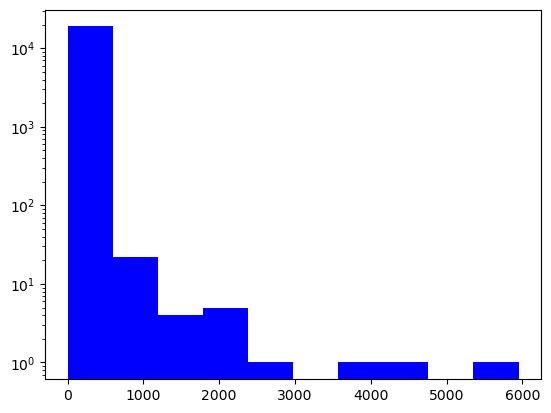

In [8]:
plt.figure()
plt.hist(aftershock_sizes, label = "size hist", color= "blue", log=True)
plt.show()

In [9]:
def fmd_values(magnitudes, bin_width=0.1):
    """
    from https://anu-rses-education.github.io/EMSC-2022/Notebooks/LAB-week8/LAB8-Gutenberg-Richter.html
    
    params magnitudes : numpy.array
    params bin_width : float
    
    returns a,b,bstd, n-values if above the earthquake count threshold
    else returns np.nans
    """
    length = magnitudes.shape[0]
    minimum = magnitudes.min()
    average = magnitudes.mean()
    b_value = (1 / (average - (minimum - (bin_width/2)))) * np.log10(np.exp(1))
    square_every_value = np.vectorize(lambda x: x**2)
    b_stddev = square_every_value((magnitudes - average).sum()) / (length * (length - 1))
    b_stddev = 2.3 * np.sqrt(b_stddev) * b_value**2
    a_value = np.log10(length) + b_value * minimum
    
    return a_value, b_value, b_stddev#, length

def omori_utsu(t, K, c, p):
    return K / ((t + c)**p)


In [10]:
def cluster_observed_rates(d_data,t_data):
    return np.diff(np.concatenate([[0], d_data])) / np.diff(np.concatenate([[0], t_data]))    

In [11]:
def cluster_parameters(cluster_data):
    max_magnitude_index = cluster_data.mag.idxmax()
    mainshock = cluster_data.loc[max_magnitude_index]
    relevant_shocks = cluster_data.loc[max_magnitude_index+1:].copy()
    
    if len(relevant_shocks)<3:
        return
    if len(relevant_shocks)>200:
        relevant_shocks = relevant_shocks[relevant_shocks['mag']>=4.5]
        
    
    relevant_shocks['cumulative_delta_days'] = relevant_shocks['delta_days'].cumsum()
    relevant_shocks['delta_days_int'] = relevant_shocks['delta_days'].astype(int)
    N_data = np.arange(1, len(relevant_shocks['cumulative_delta_days']) + 1)
    earthquakes_per_day = relevant_shocks.groupby('delta_days_int').size().reset_index(name='num_earthquakes')

    mag_data = np.array(relevant_shocks.mag.values)
    
    a_value, b_value, bstdev  = fmd_values(mag_data, bin_width=0.1)
    beta = b_value*np.log(10)
    
    relevant_shocks['a_values'] = np.log10(relevant_shocks['delta_days']) + b_value * relevant_shocks['mag']


    print(mainshock.nearest_area, mainshock.mag, len(relevant_shocks))
    print(f"Estimated a-value: {a_value:.2f}")
    print(f"Estimated b-value: {b_value:.2f}")
    print(f"Estimated beta   : {beta:.2f}")
    initial_params = [1, 1, 1]

    try:
        p_opt, p_cov = curve_fit(omori_utsu, relevant_shocks['delta_days'], N_data, p0=initial_params,maxfev=10000) #, method='dogbox',
        K_hat, c_hat, p_value = p_opt 
    except:
        try:
            p_opt, p_cov = curve_fit(omori_utsu, relevant_shocks['delta_days'], N_data, p0=initial_params,  method='lm',maxfev=10000)
            K_hat, c_hat, p_value = p_opt
        except:
            try:
                p_opt, p_cov = curve_fit(omori_utsu, relevant_shocks['delta_days'], N_data, p0=initial_params, method='dogbox',maxfev=10000)
                K_hat, c_hat, p_value = p_opt
            except:
                K_hat, c_hat, p_value = None,None,None

    try:
        print(f"Estimated K-value: {K_hat:.2f}")
        print(f"Estimated c-value: {c_hat:.2f}")
        print(f'Estimated p-value: {p_value:.2f}')  
    except:pass

    # observed_rates = cluster_observed_rates(relevant_shocks['delta_days'],relevant_shocks['cumulative_delta_days'])
    
    hist, edges = np.histogram(a=relevant_shocks.mag.values, bins=101, range=(mag_threshold-0.5,9.5))
    chist = np.cumsum(hist[::-1])[::-1]

    fig, axs = plt.subplots(2, 2, figsize=(12.5, 10))

    ax1 = axs[0, 0]
    ax1.plot(edges[:-1], chist, marker='^', color='blue', label = 'mag threshold')
    ax1.set_xlabel('Magnitude')
    ax1.set_ylabel('N')
    ax1.set_title('Gutenberg-Richter Distribution')

    ax2 = axs[0, 1]
    bin_edges = np.arange(np.min(mag_data), np.max(mag_data) + 0.1, 0.1)

    # Plot the histogram
    ax2.hist(mag_data, bins=bin_edges, color='blue', edgecolor='black', alpha=0.7, density=False, label ='Nb of shocks per mag')
    # ax2.hist(relevant_shocks.mag.values, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
    ax2.set_xlabel('Magnitude')
    ax2.set_ylabel('Frequency (normalized)')
    ax2.set_title('Gutenberg-Richter Frequency-Magnitude Plot')    

    ax3 = axs[1, 0]
    ax3.scatter(relevant_shocks['delta_days'], N_data, color='blue', label ='Observed aftershocks sequence')
    try:
        ax3.plot(relevant_shocks['delta_days'], omori_utsu(relevant_shocks['delta_days'], K_hat, c_hat, p_value), label='Omori-Utsu Law Fit', color='red')
    except:pass
    ax3.set_xlabel('Time (days)')
    ax3.set_ylabel('Number of Aftershocks')
    ax3.set_title('Omori-Utsu Law Plot')

    ax4 = axs[1, 1]
    ax4.loglog(earthquakes_per_day['delta_days_int'], earthquakes_per_day['num_earthquakes'], marker='.', linestyle='-', color='green', label = 'Shocks decay')
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.set_xlabel('Time (days)')
    ax4.set_ylabel('Number of Earthquakes per Day')
    ax4.set_title('Decay of Earthquakes per Day')

    plt.legend()
    plt.tight_layout()
    plt.show()

    return 

## Seismology

2004-12-26T00:58:53.450Z 3.295 95.982
Sumatra 9.1 1706
Estimated a-value: 8.71
Estimated b-value: 1.22
Estimated beta   : 2.80
Estimated K-value: 51.89
Estimated c-value: 0.64
Estimated p-value: -0.63


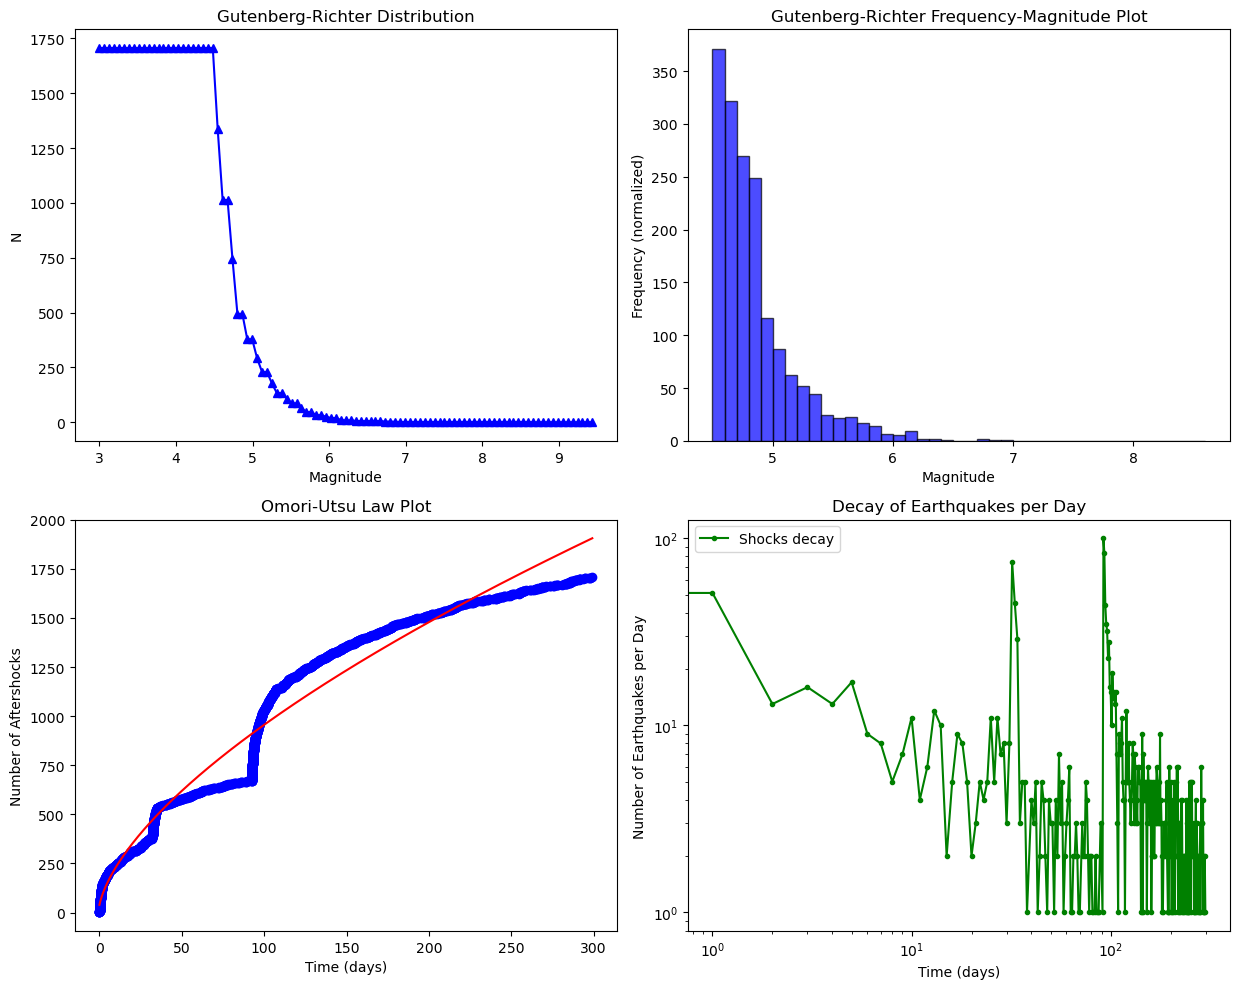

2011-03-11T05:46:24.120Z 38.297 142.373
Japan 9.1 3128
Estimated a-value: 8.53
Estimated b-value: 1.12
Estimated beta   : 2.58
Estimated K-value: 747.64
Estimated c-value: -0.01
Estimated p-value: -0.27


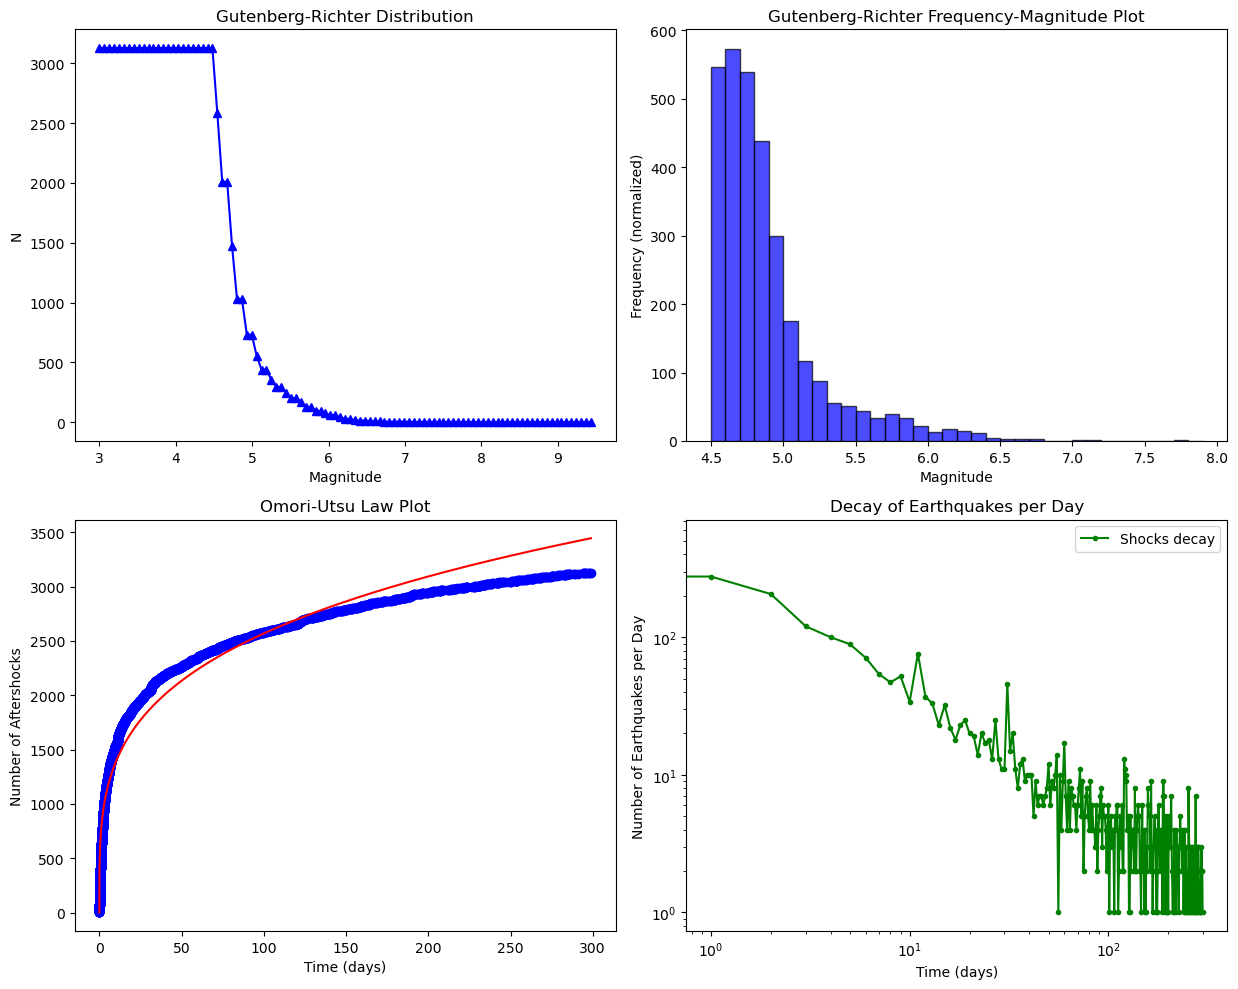

2012-04-11T08:38:36.720Z 2.327 93.063
Sumatra 8.6 305
Estimated a-value: 7.72
Estimated b-value: 1.16
Estimated beta   : 2.68
Estimated K-value: 121.83
Estimated c-value: -0.01
Estimated p-value: -0.24


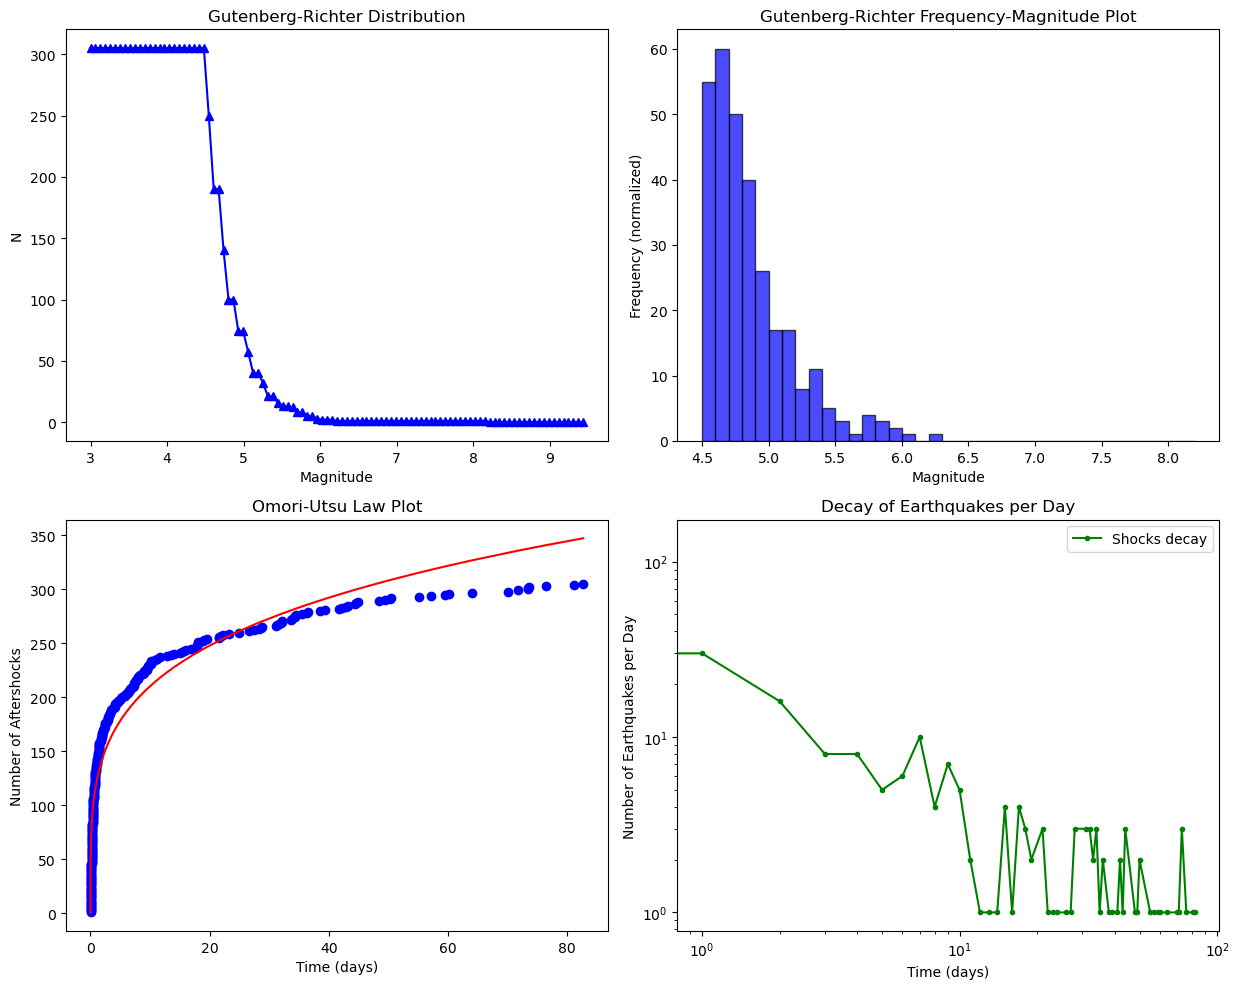

2010-02-27T06:34:11.530Z -36.122 -72.898
Chile 8.8 1124
Estimated a-value: 7.64
Estimated b-value: 1.02
Estimated beta   : 2.35
Estimated K-value: 334.50
Estimated c-value: -0.01
Estimated p-value: -0.24


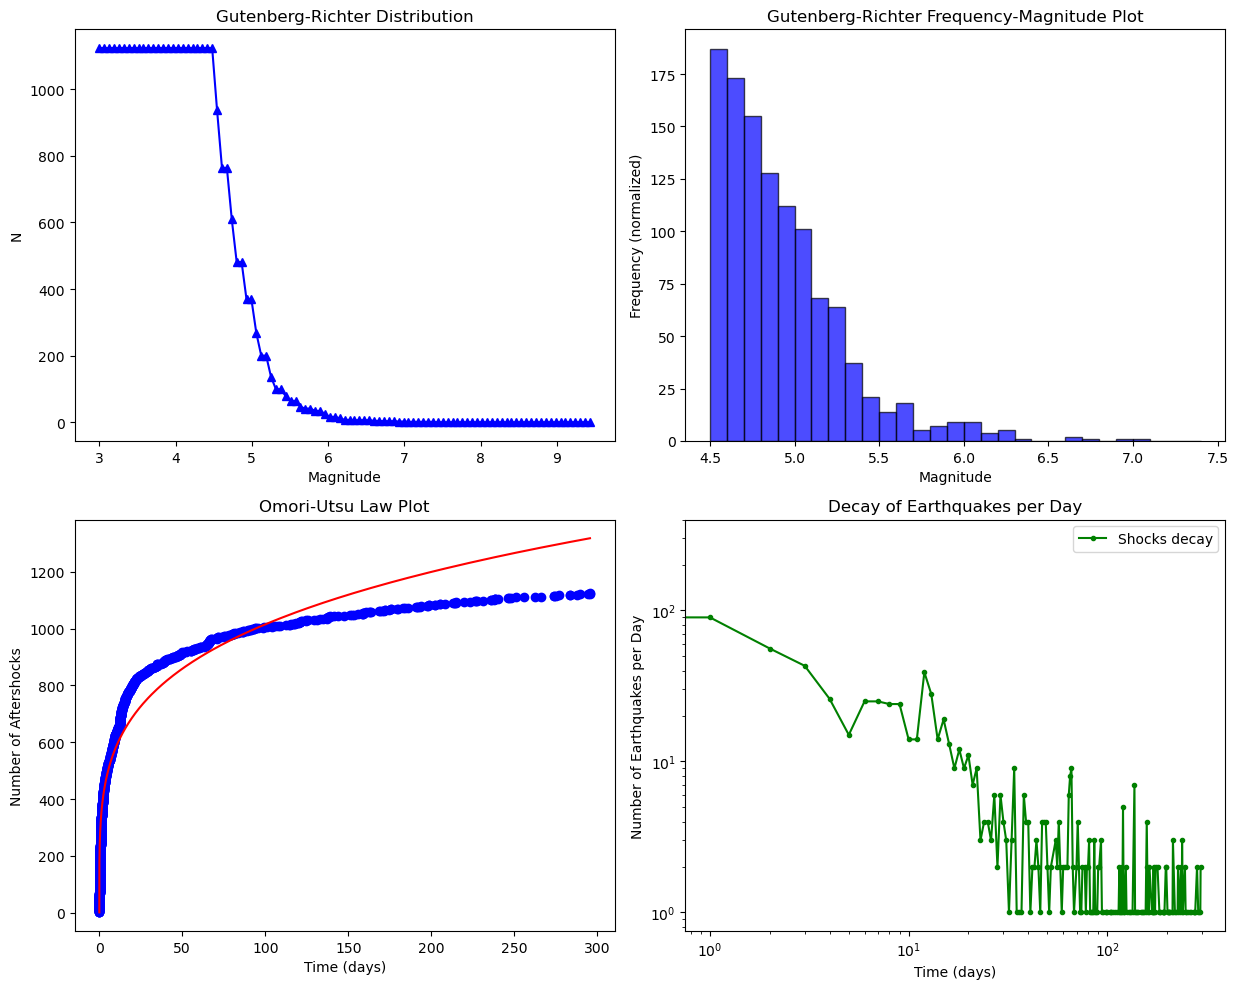

In [12]:
for cluster_label, cluster_data in clusters_data_MAS:
        
    cluster_data = cluster_data[cluster_data['mag']>mag_threshold].reset_index(drop=True)
    cluster_data.mag = cluster_data.mag.round(1)
    cluster_data = cluster_data[cluster_data['delta_days']<=300].reset_index(drop=True)

    
    mainshock = get_mainshock(cluster_data)
    mag_max = mainshock.mag
    
    if (10>mag_max>=8.6  and len(cluster_data)>=3): #and mainshock.nearest_area == 'Japan'
        print(mainshock.time, mainshock.latitude, mainshock.longitude)
        cluster_parameters(cluster_data)

---

## Features engineering

### TO DO : faire des stats sur une magnitude en général, et groupe de magnitude pour les phénomènes rares
+ utiliser bayesian rule pour apprendre ces stats


---

### Seismic regions 

From the spatial megaclusters creation from cluster_nb, we assume that megaclusters with consecutive labels are not far from each other on the earth surface. From this, to perform stats over more than one small area of one spatio temporal cluster, we can group some spatial clusters together to have more depth

We consider that under 16 spatio temporal clusters in one megacluster, we maybe dont have enough statistics to perform, so we group them

A more rigorous method would have been to keep track of the spatially close megaclusters in cluster_nb.ipynb

In [13]:
years_diff = years_since_threshold(threshold_year)

In [14]:
# adding megacluster seismicity for each MC_lab to the map
MC_map = {}
megaclusters_spatial = clusters_df.groupby(['MC_lab'])
for MC_lab, megacluster_spatial_data in megaclusters_spatial:
    nSC = megacluster_spatial_data['SC_lab'].nunique() #number of subclusters in the megacluster
    MC_map[MC_lab] = len(megacluster_spatial_data)/years_diff #/ nSC

C:\Users\ben_r\AppData\Local\Temp\ipykernel_19176\3491255495.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for MC_lab, megacluster_spatial_data in megaclusters_spatial:


In [15]:
# adding subcluster seismicity for each MC_lab to the map

MC_SC_map = {}
clusters_spatial = clusters_df.groupby(['MC_lab','SC_lab'])
for MC_SC_lab, cluster_spatial_data in clusters_spatial:
    MC_SC_map[MC_SC_lab] = len(cluster_spatial_data)/years_diff

Grouping isolated small megaclusters into larger areas

In [16]:
count_df = clusters_df.groupby('MC_lab').agg({'SC_lab': pd.Series.nunique, 'ST_lab': pd.Series.nunique}).reset_index()
count_df = count_df.rename(columns={'SC_lab': 'Unique_SC_lab_count', 'ST_lab': 'Unique_ST_lab_count'})

In [17]:
big_st_MC_lab = count_df[count_df['Unique_ST_lab_count'] > 50]
big_mc_lab_dict = dict(zip(big_st_MC_lab['MC_lab'], big_st_MC_lab['Unique_ST_lab_count']))
big_mc_lab_list = big_st_MC_lab['MC_lab'].tolist()
MC_groups = [[MC_lab] for MC_lab in big_mc_lab_list]

few_st_MC_lab = count_df[count_df['Unique_ST_lab_count'] <= 50]
few_mc_lab_dict = dict(zip(few_st_MC_lab['MC_lab'], few_st_MC_lab['Unique_ST_lab_count']))
few_mc_lab_list = few_st_MC_lab['MC_lab'].tolist()
few_lab_count_list = few_st_MC_lab['Unique_ST_lab_count'].tolist()

group_size_threshold = 120

current_group = {'MC_labs': [], 'ST_count': []}


for mc_lab, few_st_lab_count in zip(reversed(few_mc_lab_list), reversed(few_lab_count_list)): #we use reverse because in the way we did our clusters, we finished by the isolated shock cells. then we know it often contains only one cluster
    current_group['MC_labs'].append(mc_lab)
    current_group['ST_count'].append(few_st_lab_count)

    if sum(current_group['ST_count']) >= group_size_threshold:
        MC_groups.append(sorted(current_group['MC_labs'].copy()))
        current_group = {'MC_labs': [], 'ST_count': []}

if current_group['MC_labs']:
    MC_groups.append(sorted(current_group['MC_labs'].copy()))

In [18]:
MC_groups = sorted(MC_groups, key=lambda x: x[0])
f"reduced to {len(MC_groups)} seismic region on earth"

'reduced to 34 seismic region on earth'

In [19]:
# adding area (region) seismicity for each MC_lab to the map
area_map = {}
for i,group_values in enumerate(MC_groups):
    region_df = clusters_df[clusters_df['MC_lab'].isin(group_values)]
    for MC_lab in group_values:
        area_map[MC_lab] = len(region_df)/years_diff

---
### Clusters dichotomy stats

In [20]:
def compute_AS_param(relevant_shocks):
    data = np.vstack((relevant_shocks.longitude,relevant_shocks.latitude)).T
    if len(data)>1:
        cov_matrix = np.cov(data, rowvar=False)
        xy = np.mean(data, axis=0)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        if np.any(eigenvalues <= 0):
            return None,None,None,None
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        scale = np.sqrt(eigenvalues)
        std_distance = np.sqrt(np.sum(eigenvalues))
        return scale, angle, std_distance, xy
    else:
        return None,None,None,None

In [21]:
count_0 = 0
count_1 = 0

zeros_mag = []
ones_mag = []

max_dist_dict = {}

mag_bins = [0, 5, 6, 7, 10]
mag_labels = ['small', 'medium', 'moderate', 'large']
time_divisions = [1, 7, 30.5, 365.25]

cluster_stats_list = []

result_columns = ['MS_mag', 'MS_MC_lab', 'MS_SC_lab','MS_id','MS_date','MS_area','MS_lat','MS_lon','region_rate','MC_rate','SC_rate','scale','angle','std_dist', 'xy']
result_columns += [f'AS_{category}_global_{stat}' for category in mag_labels for stat in ['count', 'mag_mean', 'mag_std', 'mag_max', 'dist_mean', 'dist_std', 'dist_max']]#,'angle','std_dist','scale']]
result_columns += [f'AS_{category}_{time}_{stat}' for category in mag_labels for time in time_divisions for stat in ['count', 'mag_mean', 'mag_std', 'mag_max', 'dist_mean', 'dist_std', 'dist_max']]
# result_df = pd.DataFrame(columns=result_columns)

for cluster_label, cluster_data in clusters_data_MAS:
    mainshock = get_mainshock(cluster_data).copy()
    max_mag = round(mainshock.mag,1)
    key_tuple = (mainshock['MC_lab'], mainshock['SC_lab'])
    
    row = [mainshock['mag'], mainshock['MC_lab'], mainshock['SC_lab'], mainshock['id'], mainshock['time'], mainshock['nearest_area'],mainshock['latitude'],mainshock['longitude'],
           area_map[mainshock['MC_lab']],MC_map[mainshock['MC_lab']], MC_SC_map[key_tuple]]
    
    if len(cluster_data)>1:
        
        if max_mag not in max_dist_dict.keys():
            max_dist_dict[max_mag] = []
        max_dist_dict[max_mag].append(cluster_data.delta_dist.max())
        
        max_magnitude_index = cluster_data.mag.idxmax()
        mainshock = cluster_data.loc[max_magnitude_index]
        relevant_shocks = cluster_data.loc[max_magnitude_index+1:].copy()
        
        # if len(relevant_shocks)>=1:
        relevant_shocks['mag_category'] = pd.cut(cluster_data['mag'], bins=mag_bins, labels=mag_labels)

        scale, angle, std_distance, xy = compute_AS_param(relevant_shocks)
        
        row += [scale, angle, std_distance, xy]

        for category in mag_labels:
            category_data = relevant_shocks[relevant_shocks['mag_category'] == category]
            row += [
                category_data['mag'].count(),
                category_data['mag'].mean(),
                category_data['mag'].std(),
                category_data['mag'].max(),
                category_data['delta_dist'].mean(),
                category_data['delta_dist'].std(),
                category_data['delta_dist'].max()
            ]

            for time_div in time_divisions:
                time_data = category_data[category_data['delta_days'] <= time_div]
                row += [
                    time_data['mag'].count(),
                    time_data['mag'].mean(),
                    time_data['mag'].std(),
                    time_data['mag'].max(),
                    time_data['delta_dist'].mean(),
                    time_data['delta_dist'].std(),
                    time_data['delta_dist'].max()
                ]
        cluster_stats_list.append(row)
        count_1 +=1
        ones_mag.append(mainshock.mag)
     
    else:
        row+= [None for i in range (len(result_columns)-len(row))]
        cluster_stats_list.append(row)
        # result_df.loc[len(result_df)] = [item for sublist in row for item in sublist]
        count_0 +=1
        zeros_mag.append(mainshock.mag)

cluster_stats_df = pd.DataFrame(cluster_stats_list, columns=result_columns)
cluster_stats_df['AS_tot_count'] = cluster_stats_df['AS_small_global_count'] + cluster_stats_df['AS_medium_global_count'] + cluster_stats_df['AS_moderate_global_count'] + cluster_stats_df['AS_large_global_count']

max_dist_dict = dict(sorted(max_dist_dict.items()))
count_0,count_1

(11171, 7797)

### Adding seismicity rates (coefs to tune)

    region rate is the rate (nb of shocks / year) over a large area : dont take into account the number of subclusters inside this area.
    MC_rate is the rate over the megacluster area : take into account the number of subclusters inside this area.
    SC_rate is the rate over the subcluster area.

In [22]:
# filtered_rows = result_df[result_df['AS_large_1_dist_max'].notna()]
area_coef = 1
MC_coef = 2
SC_coef = 6
cluster_stats_df['weighted_rate'] = (area_coef*cluster_stats_df['region_rate'] + MC_coef*cluster_stats_df['MC_rate'] + SC_coef*cluster_stats_df['SC_rate'])/(area_coef+MC_coef+SC_coef)
cluster_stats_df.iloc[:, :]#.sort_values('MS_date')

MS_mag  MS_MC_lab  MS_SC_lab       MS_id                   MS_date  \
0         5.1          0          0  usp00076bd  1995-11-05T17:14:53.680Z   
1         5.2          0          0  us60007f7v  2020-01-24T22:56:05.315Z   
2         5.7          0          0  us7000dkv0  2021-03-19T06:11:27.113Z   
3         5.7          0          0  us6000iaqi  2022-08-14T08:20:00.340Z   
4         5.0          0          0  us7000iltn  2022-11-01T22:06:54.963Z   
...       ...        ...        ...         ...                       ...   
18963     5.8        421          0  usp00082nd  1997-05-21T22:51:28.730Z   
18964     5.1        422          0  usp000gze0  2009-07-18T20:32:29.990Z   
18965     5.3        423          0  usb000q6by  2014-05-01T15:21:13.720Z   
18966     5.2        424          0  us100061v2  2016-07-08T09:40:50.000Z   
18967     5.0        425          0  usp000br8c  2003-02-22T20:41:03.420Z   

         MS_area   MS_lat    MS_lon  region_rate      MC_rate  ...  \
0          China  32.8960   92.2010  7021.989201  7021.989201  ...   
1          China  31.9950   95.0575  7021.989201  7021.989201  ...   
2          China  31.9246   92.9151  7021.989201  7021.989201  ...   
3          China  33.1157   92.7977  7021.989201  7021.989201  ...   
4          China  33.1963   92.0137  7021.989201  7021.989201  ...   
...          ...      ...       ...          ...          ...  ...   
18963      India  23.0830   80.0410     6.296817     0.034598  ...   
18964       Iraq  35.8880   43.3530     6.296817     0.034598  ...   
18965      Palau   6.5114  130.1431     6.296817     0.034598  ...   
18966  Australia -32.4580  122.5110     6.296817     0.034598  ...   
18967     France  48.3420    6.5700     6.296817     0.069196  ...   

       AS_large_30.5_dist_max AS_large_365.25_count  AS_large_365.25_mag_mean  \
0                         NaN                   NaN                       NaN   
1                         NaN                   NaN                       NaN   
2                         NaN                   0.0                       NaN   
3                         NaN                   0.0                       NaN   
4                         NaN                   NaN                       NaN   
...                       ...                   ...                       ...   
18963                     NaN                   NaN                       NaN   
18964                     NaN                   NaN                       NaN   
18965                     NaN                   NaN                       NaN   
18966                     NaN                   NaN                       NaN   
18967                     NaN                   0.0                       NaN   

       AS_large_365.25_mag_std AS_large_365.25_mag_max  \
0                          NaN                     NaN   
1                          NaN                     NaN   
2                          NaN                     NaN   
3                          NaN                     NaN   
4                          NaN                     NaN   
...                        ...                     ...   
18963                      NaN                     NaN   
18964                      NaN                     NaN   
18965                      NaN                     NaN   
18966                      NaN                     NaN   
18967                      NaN                     NaN   

       AS_large_365.25_dist_mean  AS_large_365.25_dist_std  \
0                            NaN                       NaN   
1                            NaN                       NaN   
2                            NaN                       NaN   
3                            NaN                       NaN   
4                            NaN                       NaN   
...                          ...                       ...   
18963                        NaN                       NaN   
18964                        NaN                       NaN   
18965        

In [23]:
numeric_columns = cluster_stats_df.select_dtypes(include=['number']).columns
fill_values = {column: 0 for column in numeric_columns}
cluster_stats_df.fillna(value=fill_values, inplace=True)

#cluster_stats_df.to_csv('test.csv')

In [24]:
mag_5 = (cluster_stats_df['MS_mag'] == 5).sum()
mag_51 = (cluster_stats_df['MS_mag'] == 5.1).sum()
mag_52 = (cluster_stats_df['MS_mag'] == 5.2).sum()
mag_53 = (cluster_stats_df['MS_mag'] == 5.3).sum()
mag_54 = (cluster_stats_df['MS_mag'] == 5.4).sum()
count_between_55_and_56 = ((cluster_stats_df['MS_mag'] >= 5.5) & (cluster_stats_df['MS_mag'] <= 5.6)).sum()
count_between_57_and_6 = ((cluster_stats_df['MS_mag'] >= 5.7) & (cluster_stats_df['MS_mag'] < 6)).sum()
count_between_6_and_7 = ((cluster_stats_df['MS_mag'] >= 6) & (cluster_stats_df['MS_mag'] < 7)).sum()
count_above_7 = (cluster_stats_df['MS_mag'] >= 7).sum()

mag_5, mag_51, mag_52,mag_53,mag_54,count_between_55_and_56,count_between_57_and_6, count_between_6_and_7, count_above_7

(3287, 2740, 2273, 1854, 1629, 2385, 2140, 2253, 361)

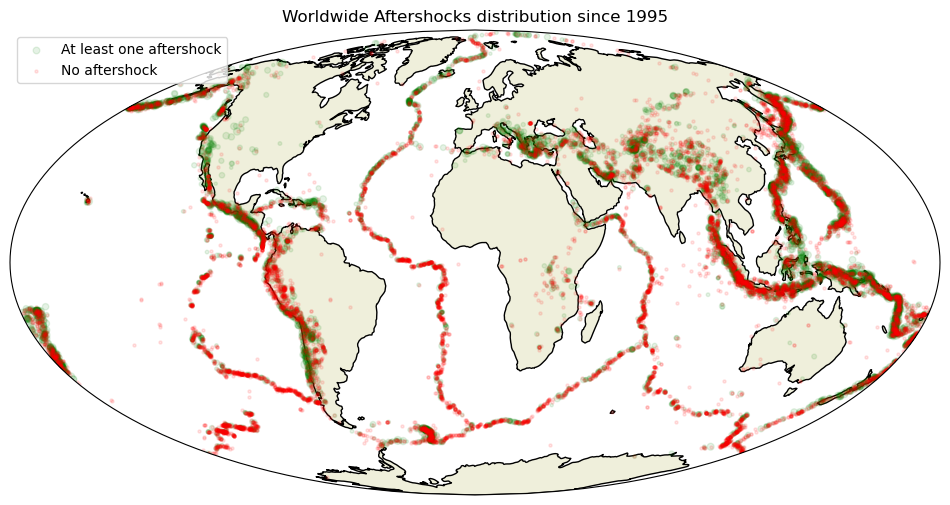

In [25]:
filtered_df = cluster_stats_df[(cluster_stats_df['AS_tot_count'].notna()) & (cluster_stats_df['AS_tot_count'] > 0)]

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.Mollweide()})
ax.add_feature(cfeature.LAND, edgecolor='black')

ax.scatter(filtered_df['MS_lon'], filtered_df['MS_lat'], s=5*np.log(filtered_df['AS_tot_count']), color='green', alpha = 0.1, label='At least one aftershock', transform=ccrs.PlateCarree())
ax.scatter(cluster_stats_df.loc[cluster_stats_df['AS_tot_count'].isna() | (cluster_stats_df['AS_tot_count'] == 0), 'MS_lon'],
           cluster_stats_df.loc[cluster_stats_df['AS_tot_count'].isna() | (cluster_stats_df['AS_tot_count'] == 0), 'MS_lat'],
           s = 5, color='red', alpha = 0.1, label='No aftershock', transform=ccrs.PlateCarree())

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
ax.set_title('Worldwide Aftershocks distribution since 1995')

plt.show()

not looking to be easily separable to predict if there will be an aftershock or not

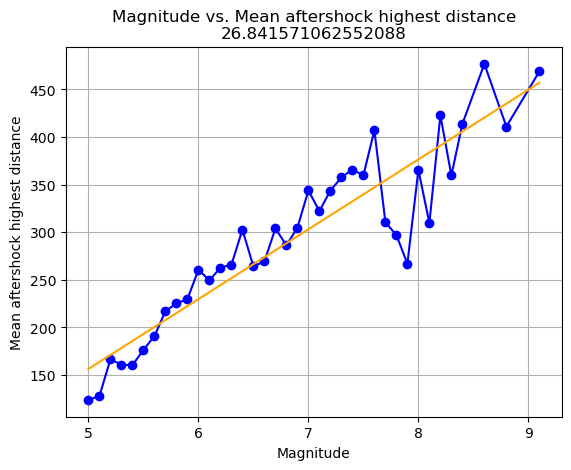

In [26]:
#averaged max triggering distance

magnitudes = np.array(list(max_dist_dict.keys()))
mean_distances = np.array([np.mean(dists) for dists in max_dist_dict.values()])

plt.plot(magnitudes, mean_distances, color = 'b',marker='o', linestyle='-')

# Performing linear regression
slope, intercept, r_value, p_value, std_err = linregress(magnitudes, mean_distances)
linear_fit = slope * magnitudes + intercept
residual = np.mean(np.abs(mean_distances - linear_fit))
plt.plot(magnitudes, linear_fit, color='orange', label='Linear Regression')

plt.xlabel('Magnitude')
plt.ylabel('Mean aftershock highest distance')
plt.title(f'Magnitude vs. Mean aftershock highest distance\n{residual}')
plt.grid(True)
plt.show()

    From this graph we can conclude that usually, the larger the magnitude of a mainshock is, the higher is its triggering distance (distance at which an afterhock can occur, due to the mainshock). We observe a low value at mag 7.9, suggesting we may not have quality clusters at this magnitude or the few observations demonstrated low triggering distance.

    We can use this information in the decision tree

In [27]:
# np.quantile(zeros_mag,[0.25,0.5,0.75,0.95,0.99])

In [28]:
# np.quantile(ones_mag,[0.25,0.5,0.75,0.95, 0.99])

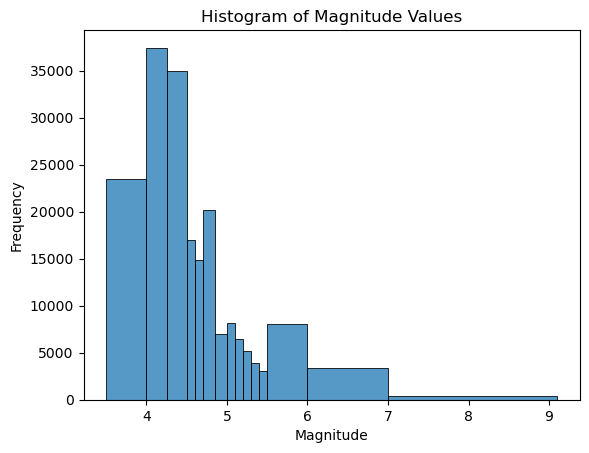

In [29]:
world_area_df = clusters_df.copy()[clusters_df['delta_days']>=0.].reset_index(drop=True)
asian_area_df = world_area_df.copy()[world_area_df['MC_lab'] == 0].reset_index(drop=True)
japan_area_df = asian_area_df.copy()[(asian_area_df['latitude'] >= 20) & (asian_area_df['latitude'] <= 50) & (asian_area_df['longitude'] >= 120) & (asian_area_df['latitude'] <= 150) & (asian_area_df['delta_days']>=0.)].reset_index(drop=True)

grouped_world_df = world_area_df.groupby(['MC_lab','SC_lab', 'ST_lab'])
grouped_asia_df = asian_area_df.groupby(['SC_lab', 'ST_lab'])
grouped_japan_df = japan_area_df.groupby(['SC_lab', 'ST_lab'])

chosen_df = 'world'
cols_group = ['MC_lab','SC_lab', 'ST_lab'] if chosen_df == 'world' else ['SC_lab', 'ST_lab']

if chosen_df == 'world':
    dataframe = world_area_df.copy()
elif chosen_df == 'asia':
    dataframe = asian_area_df.copy()
else:
    dataframe = japan_area_df.copy()

grouped_dataframe = dataframe.groupby(cols_group)
f"we will work on {len(dataframe)} quakes spread over {len(grouped_dataframe)} clusters"


min_mag = dataframe.mag.min()
max_mag = dataframe.mag.max()
bin_ranges = [min_mag,4,4.25,4.5,4.6,4.7,4.85,5,5.1,5.2,5.3,5.4,5.5,6,7,max_mag]
# print(len(bin_ranges))
sns.histplot(dataframe.mag, bins=bin_ranges, kde=False)

plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of Magnitude Values')

plt.show()

In [30]:
# dist_bin_range = np.linspace(0,n_days_df['delta_dist'].max(), len(mag_bin_range))
# days_bin_range = np.linspace(0,n_days_df['delta_days'].max(), len(mag_bin_range))
# X, Y, Z = np.meshgrid(dist_bin_range, days_bin_range, mag_bin_range)
# print(X.shape, Y.shape, Z.shape)

# z = xx*0+yy*0+ np.random.random(size=[7,7])

## Kernel Density

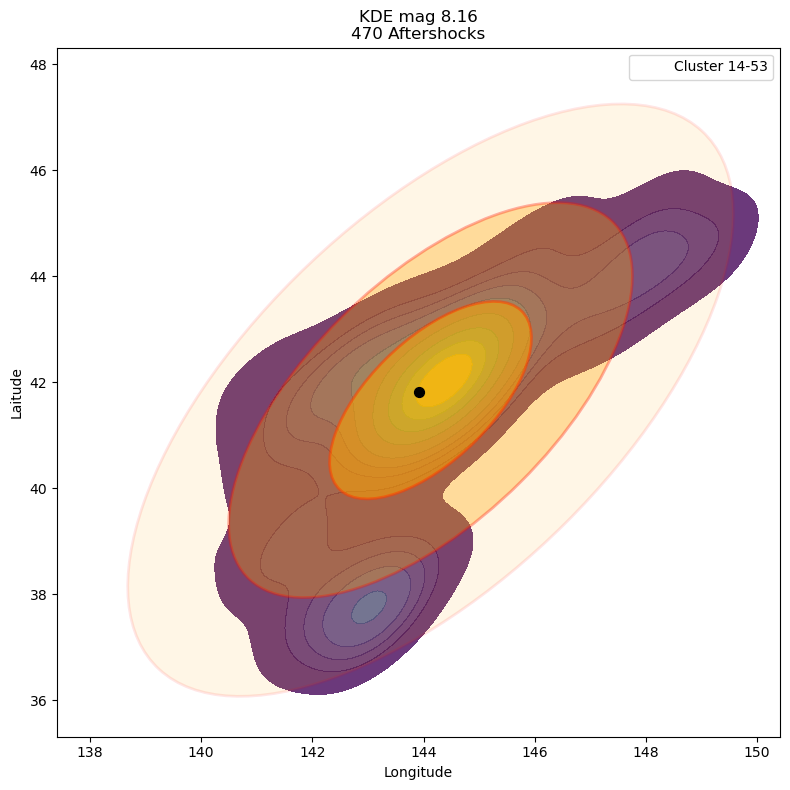

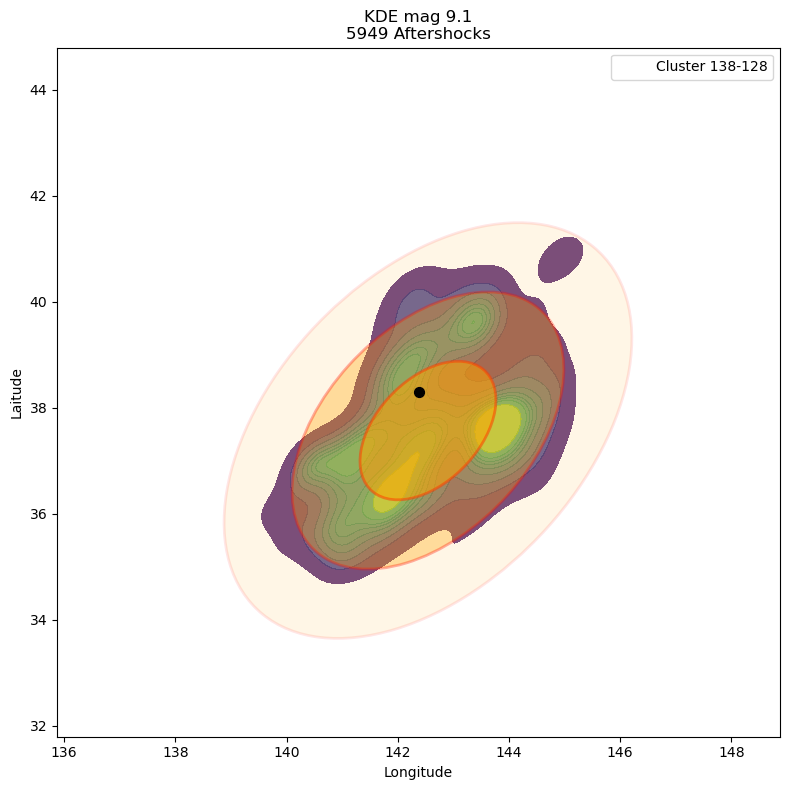

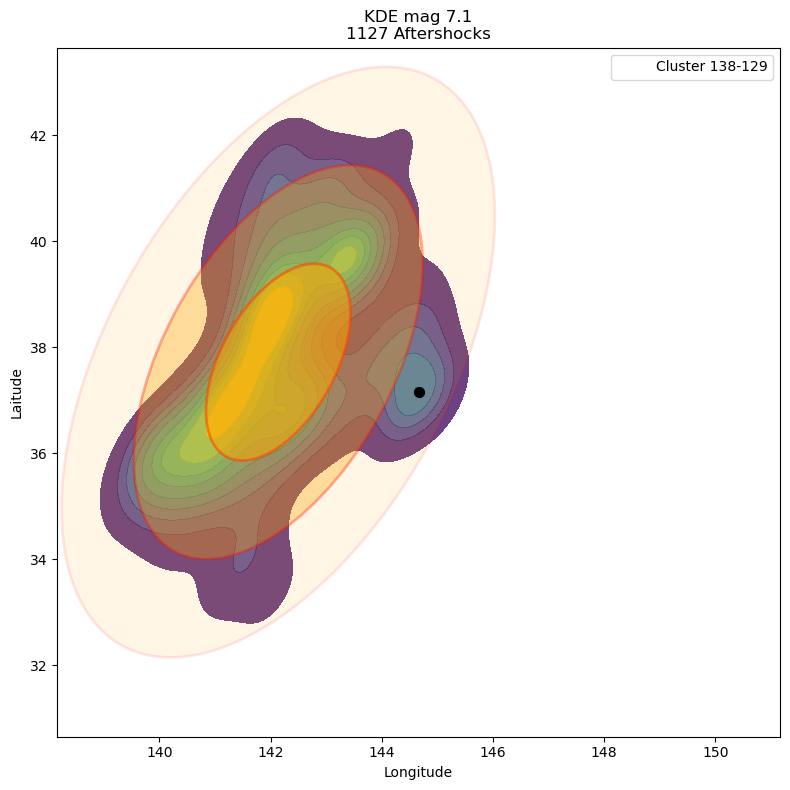

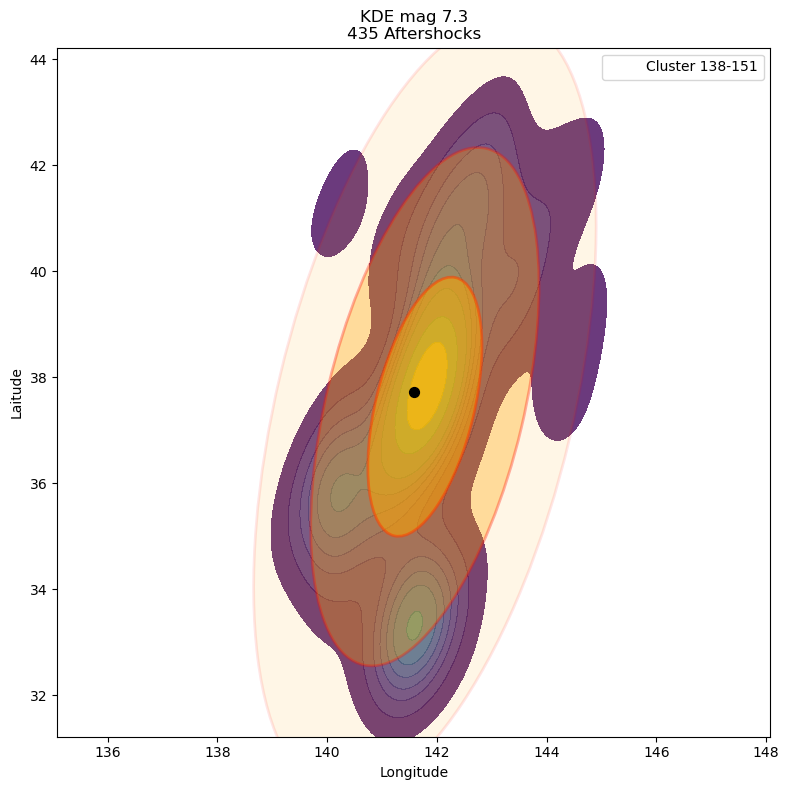

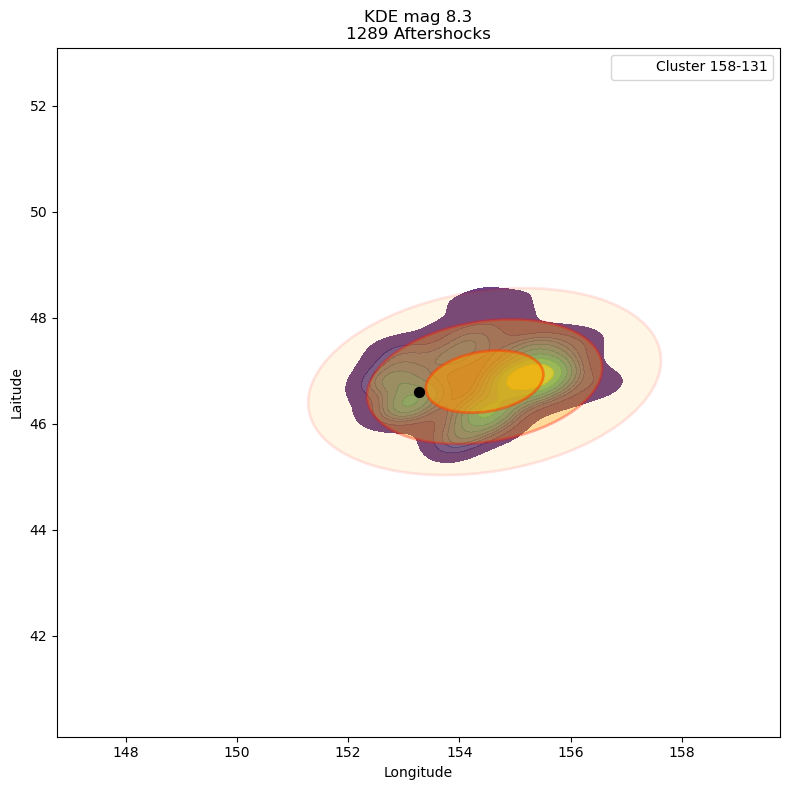

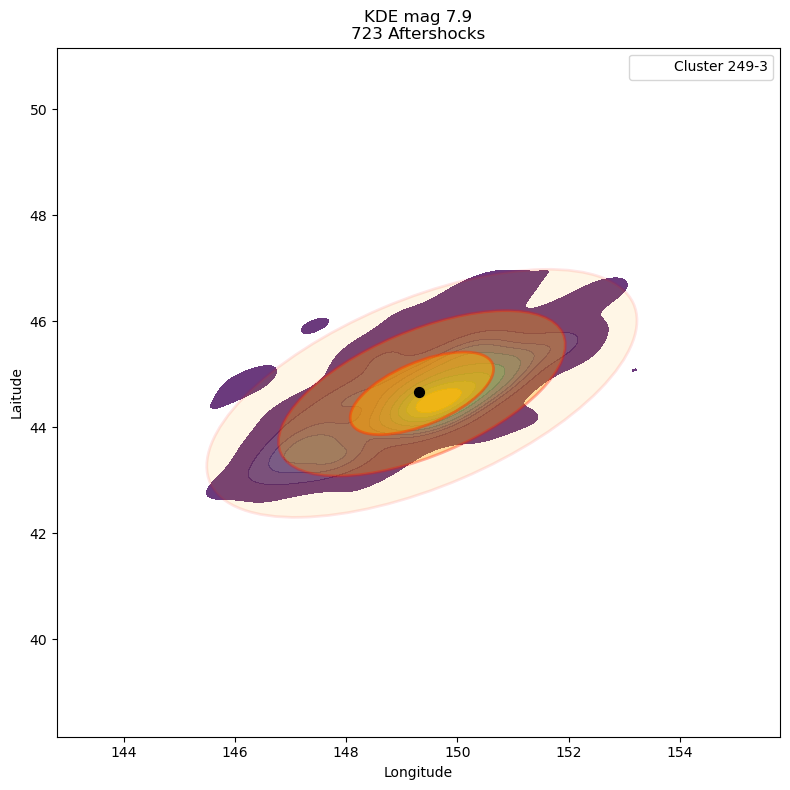

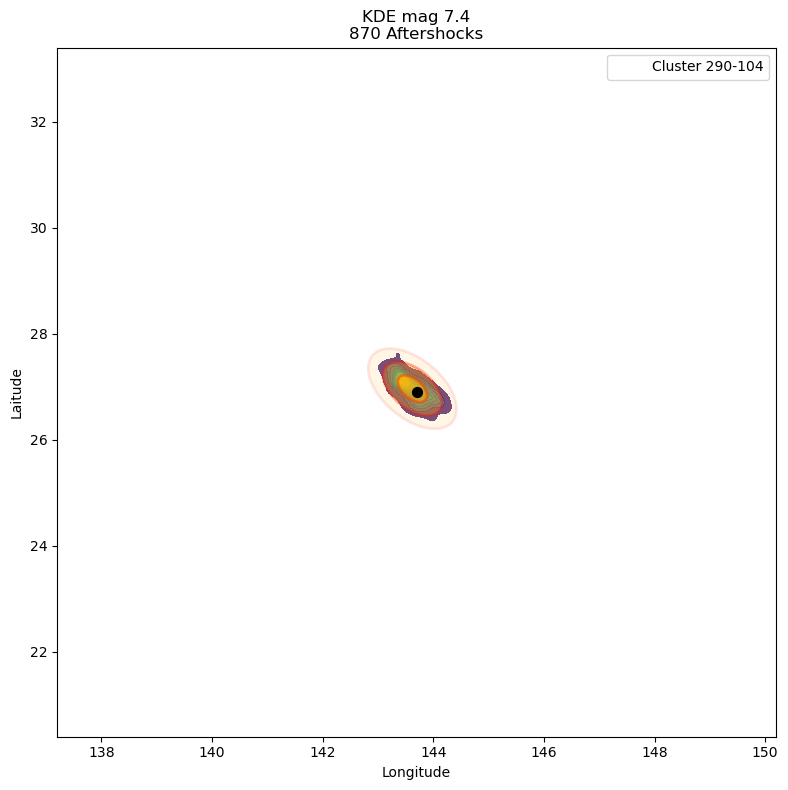

7

In [31]:
count = 0

for (sc_lab, st_lab), group_df in grouped_japan_df:
    if len(group_df)>= 400 and group_df.mag.max() > 6.2:
        
        plt.show()
        plt.show()
        center_lat = group_df.iloc[0].latitude
        center_lon = group_df.iloc[0].longitude

        data = np.vstack((group_df.iloc[1:].longitude,group_df.iloc[1:].latitude)).T

        cov_matrix = np.cov(data, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        # Get the angle of the major axis from the eigenvectors
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

        std_distance = np.sqrt(np.sum(eigenvalues))

        weights = group_df.mag**3
        # norm = Normalize(vmin=weights.min(), vmax=weights.max())
        # normalized_weights = (3.5 + (weights - weights.min()) / (weights.max() - weights.min()) * (9.1 - 3.5))**3
    
        fig, ax = plt.subplots(figsize=(8,8))
        
        sns.kdeplot(data=group_df, x='longitude', y='latitude', weights=weights,
                    fill=True, ax=ax, cmap='viridis', alpha = 0.8,
                    label = f"Cluster {sc_lab}-{st_lab}")
        
        for n in range(1, 4):
            scale = np.sqrt(eigenvalues) * n

            ellipse = plt.matplotlib.patches.Ellipse(
                xy=np.mean(data, axis=0),
                width=scale[0] * 2,
                height=scale[1] * 2,
                angle=angle,
                edgecolor='red',
                facecolor='orange',
                linewidth=2,
                alpha = 1-(n+1)*0.225
            )
            ax.add_patch(ellipse)

        ax.scatter(center_lon,center_lat, color = 'black', s = 50)


        ax.set_title(f'KDE mag {group_df.mag.max()}\n{len(group_df)-1} Aftershocks')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Laitude')
        ax.set_xlim(center_lon-6.5, center_lon+6.5)        
        ax.set_ylim(center_lat-6.5, center_lat+6.5)
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        count+=1
count

---

## Plot cluster

In [32]:
def grid_for_map(main_earthquake,aftershocks):
    resolution = 5e-3
    main_earthquake_grid_cell = main_earthquake.grid_cell
    if isinstance(main_earthquake_grid_cell, str):
        main_earthquake_grid_cell = tuple(map(int, main_earthquake_grid_cell.strip('()').split(',')))
    i,j = main_earthquake_grid_cell[0],main_earthquake_grid_cell[1]

    min_lat,min_lon,max_lat,max_lon = get_cell_coordinates(grid,i,j)

    unzoom_data = int(aftershocks.delta_dist.max()/111)+1 # 1°of latitude or longitude is approximately equals to 111 km then we transform the distance in km to °
    x = np.arange(min_lon-unzoom_data, max_lon+unzoom_data, resolution)
    y = np.arange(min_lat-unzoom_data, max_lat+unzoom_data, resolution)
    
    return x,y

In [33]:
def density_func(x, y, cluster, mag_power = 4):
    xx, yy = np.meshgrid(x, y)
    kde = gaussian_kde(np.vstack([cluster['longitude'], cluster['latitude']]), weights= cluster['mag']**mag_power)

    # Calculate the density for each point in the grid
    density = kde(np.vstack([xx.ravel(), yy.ravel()]))
    density = density / density.max()  # Normalize the density values
    return density.reshape(xx.shape)

In [34]:
def square_degrees_2_square_km_approximation(latitude,area):
    lat_radians = np.radians(np.mean(latitude))
    # Conversion factor from square degrees to square kilometers
    conversion_factor = 111 * 111 * np.cos(lat_radians)
    return area * conversion_factor    

In [35]:
area_of_interest = 'Japan'  #
min_mag_of_interest = 8.7  # 5 if no specific condition
max_mag_of_interest = 10   #10 if no specific condition

foreshocks_threshold = True
aftershocks_threshold = True

fore_days_threshold = 15
after_days_threshold = 30

aftershocks_only = True

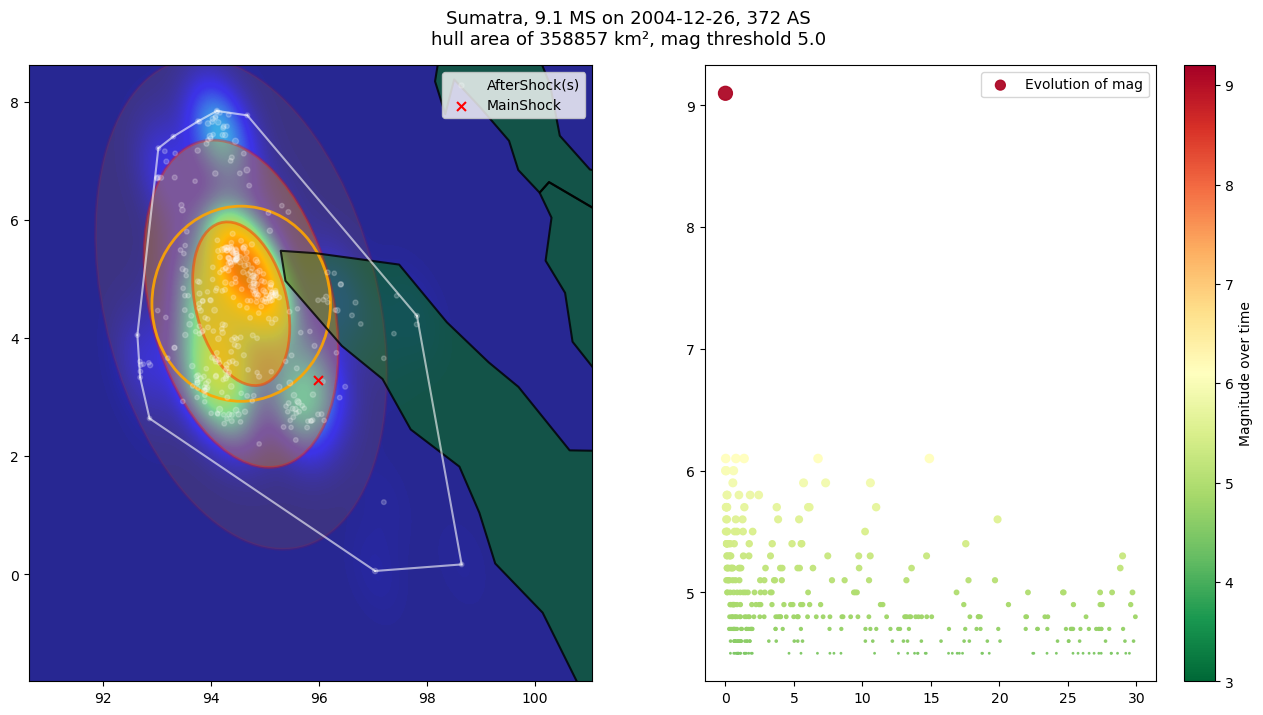

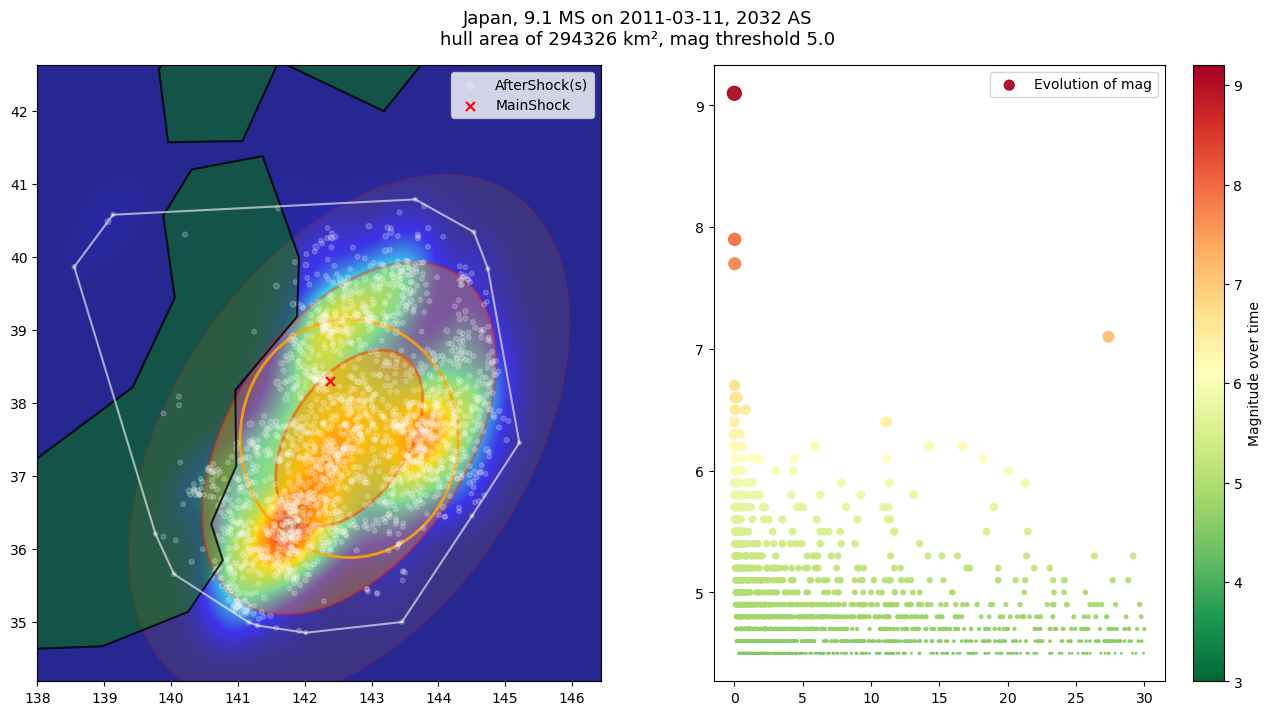

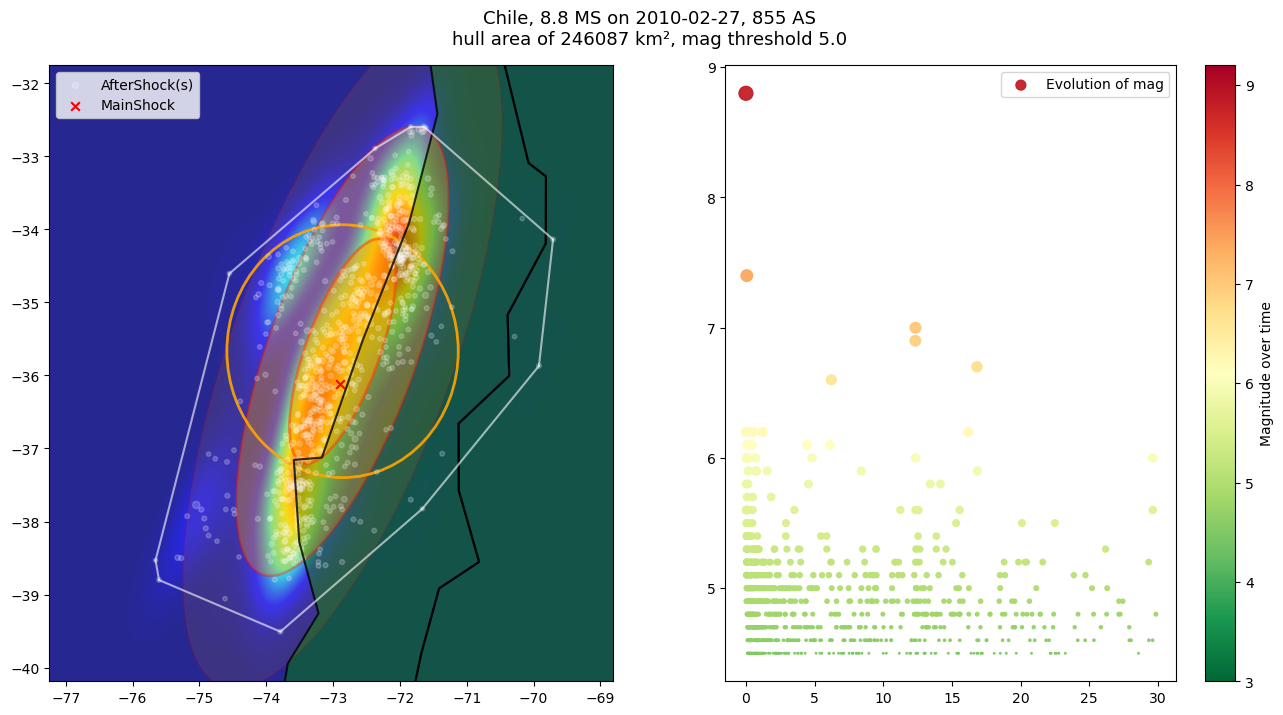

In [36]:
for cluster_label, cluster_data in clusters_data_MAS:
    
    mag_threshold = 3.5
    if len(cluster_data)>=500:
        mag_threshold = 5.
        
    cluster_data = cluster_data[cluster_data['mag']>=4.5].reset_index(drop=True)
    if foreshocks_threshold:
        cluster_data = cluster_data[cluster_data['delta_days']>=-foreshocks_threshold].reset_index(drop=True)
    if aftershocks_threshold:
        cluster_data = cluster_data[cluster_data['delta_days']<=after_days_threshold].reset_index(drop=True)
    if aftershocks_only:
        cluster_data = cluster_data[0<=cluster_data['delta_days']].reset_index(drop=True)
    
    if len(cluster_data)==0:
        continue
    
    mag_max = cluster_data.mag.max()
    mag_min = cluster_data.mag.min()
    
    if (min_mag_of_interest <= mag_max <= max_mag_of_interest):
        # near_areas = set(cluster_data.nearest_area.tolist())
        
        # if area_of_interest in near_areas:
            
            cluster_data['time'] = pd.to_datetime(cluster_data['time'])
            cluster_data['date'] = cluster_data['time'].dt.date

            cluster_data['normalized_mag'] = (cluster_data['mag'] - (mag_min-0.1)) / (mag_max - (mag_min-0.1))
            cluster_data['marker_size'] = cluster_data['normalized_mag'].apply(custom_marker_size, args=(max_mag,))*1.2
            
            max_magnitude_index = cluster_data.mag.idxmax()
            main_earthquake = cluster_data.loc[max_magnitude_index]
            aftershocks = cluster_data.loc[max_magnitude_index + 1:]
            relevant_shocks = cluster_data.loc[max_magnitude_index:]
                                    
            near_area = main_earthquake.nearest_area

            x,y = grid_for_map(main_earthquake,aftershocks)
            kde = density_func(x, y, relevant_shocks, mag_power = 4)

            data = np.vstack((aftershocks.longitude,aftershocks.latitude)).T
            
            hull = ConvexHull(data)
            area = hull.volume
            area_km = round(square_degrees_2_square_km_approximation(aftershocks.latitude,area))
            
            cov_matrix = np.cov(data, rowvar=False)
            eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
            # Get the angle of the major axis from the eigenvectors
            angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

            std_distance = np.sqrt(np.sum(eigenvalues))
            
            _, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 8))
            ax1.set_xlim(x.min(), x.max())
            ax1.set_ylim(y.min(), y.max())
    
            world.boundary.plot(ax=ax1, color='black', alpha = 0.8)
            world.plot(ax=ax1, color="green", alpha=0.5)
            
            cmap_density = 'jet'
            norm_density = plt.Normalize(vmin=kde.min(), vmax=kde.max())
            smd = plt.cm.ScalarMappable(cmap=cmap_density, norm=norm_density)
            smd.set_array([])  # This line is necessary to connect the colormap to the data
            ax1.imshow(kde, cmap=cmap_density, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', alpha=0.85,  aspect="auto")
    
            for simplex in hull.simplices:
                ax1.plot(data[simplex, 0], data[simplex, 1], color='white',alpha=0.6)

            for n in range(1, 4):
                scale = np.sqrt(eigenvalues) * n

                ellipse = plt.matplotlib.patches.Ellipse(
                    xy=np.mean(data, axis=0),
                    width=scale[0] * 2,
                    height=scale[1] * 2,
                    angle=angle,
                    edgecolor='red',
                    facecolor='orange',
                    linewidth=2,
                    alpha = 1-(n+1)*0.225
                )
                ax1.add_patch(ellipse)

            circle = plt.matplotlib.patches.Circle(
            xy=np.mean(data, axis=0),
            radius=std_distance,
            edgecolor='orange',
            facecolor='none',
            linewidth=2,
            alpha = 0.9
            )
            
            ax1.add_patch(circle)
                
            if max_magnitude_index > 0:
                foreshocks = cluster_data.loc[:max_magnitude_index - 1]
                ax1.scatter(foreshocks.longitude,foreshocks.latitude, alpha = 0.2, s = foreshocks.mag**2/2, color = 'purple', label = "Foreshock(s)")
                ax2.scatter(foreshocks.delta_days,foreshocks.mag, alpha = 0.2, s = foreshocks.mag**2/2, color = 'purple', label = "Foreshock(s)")
                
            ax1.scatter(aftershocks.longitude,aftershocks.latitude, alpha = 0.2, s = aftershocks.mag**2/2, color = 'white', label = "AfterShock(s)")
            ax1.scatter(main_earthquake.longitude,main_earthquake.latitude, s = main_earthquake.mag**2/2, marker = 'x', color = 'red', label = "MainShock")
                
            cmapm = plt.get_cmap('RdYlGn_r')
            normm = mcolors.Normalize(vmin=3., vmax=9.2)
            colors = cmapm(normm(relevant_shocks.mag))

            ax2.scatter(relevant_shocks.delta_days, relevant_shocks.mag,
            s=relevant_shocks['marker_size'],
            c=colors,
            alpha=0.95,
            label='Evolution of mag')
            
            # ax2.scatter(aftershocks.delta_days,aftershocks.mag, alpha = 0.2, s = aftershocks.mag**2/2, color = 'blue', label = "AfterShock(s)")
            # ax2.scatter(main_earthquake.delta_days,main_earthquake.mag, s = main_earthquake.mag**2/2, color = 'red', label = "MainShock")
            
            ax1.legend()
            ax2.legend()
                    
            smm = ScalarMappable(cmap=cmapm, norm=normm)
            smm.set_array([])
            plt.colorbar(smm, ax=ax2,label='Magnitude over time', orientation='vertical')
            
            plt.suptitle(f'{near_area}, {mag_max} MS on {main_earthquake.date}, {len(aftershocks)} AS\nhull area of {area_km} km², mag threshold {mag_threshold}', fontsize=13, y = 0.95)

            plt.show()

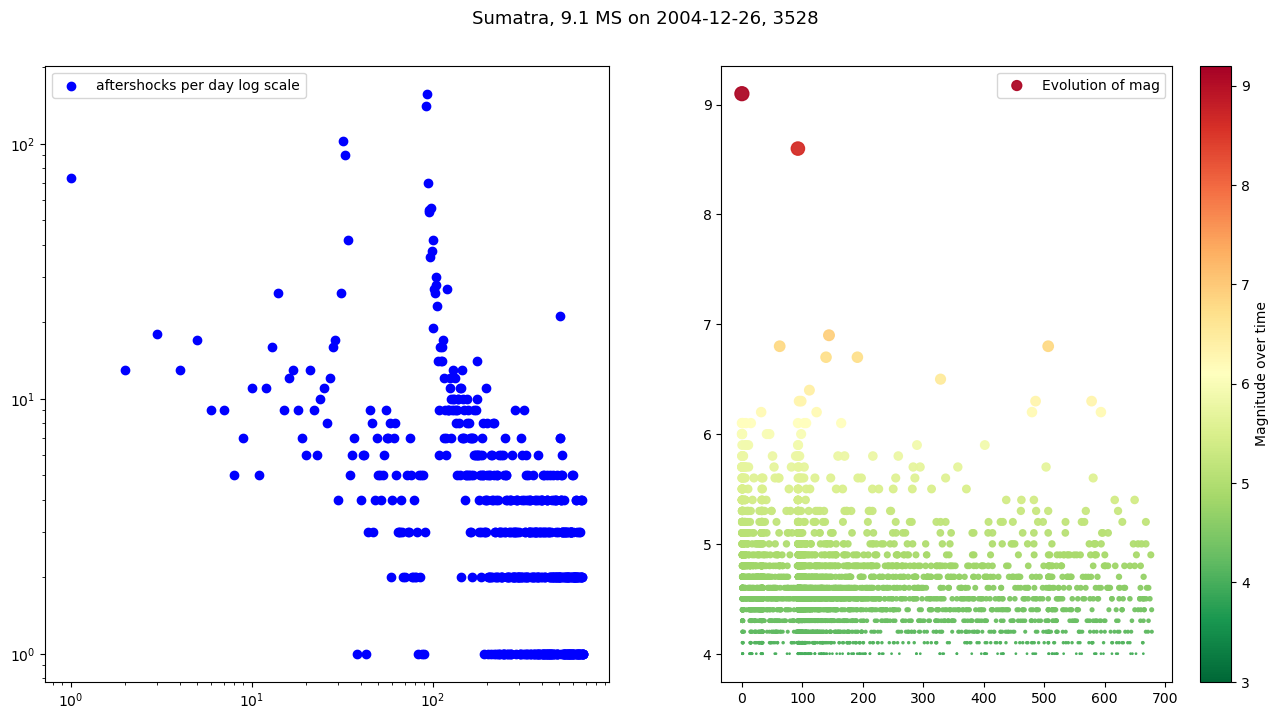

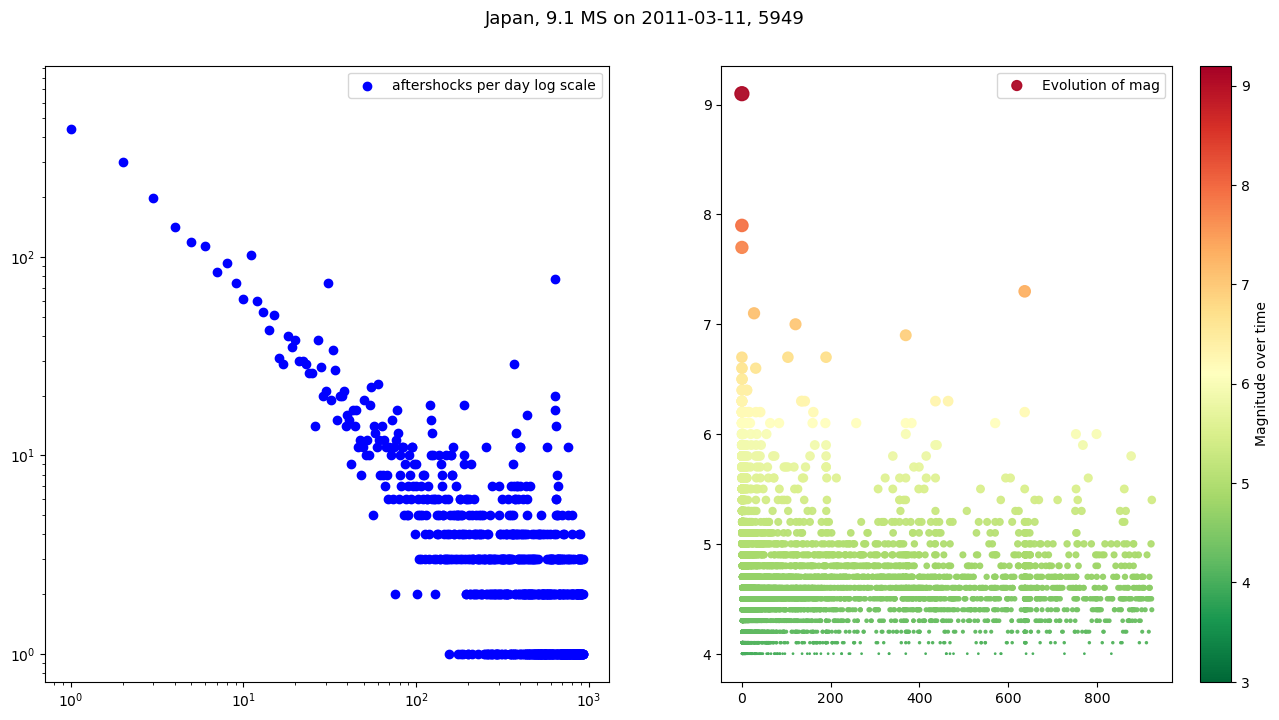

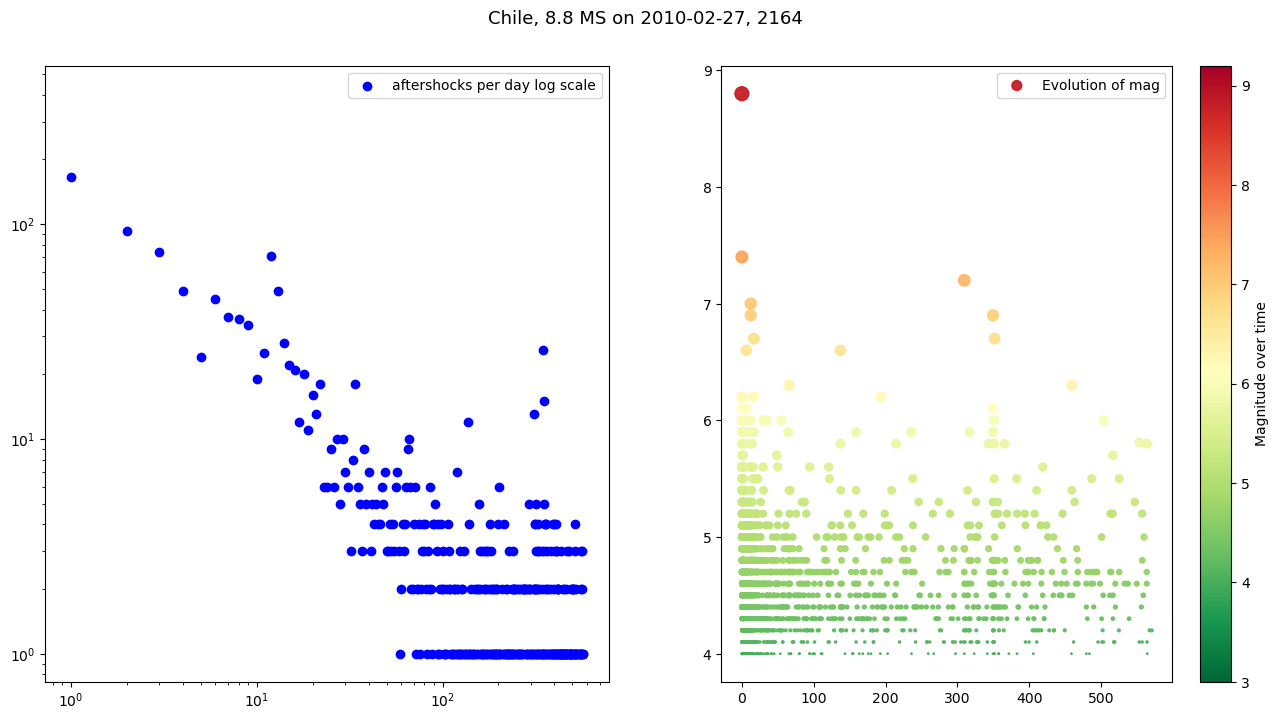

In [37]:
for cluster_label, cluster_data in clusters_data_MAS:
    
    cluster_data = cluster_data[0<=cluster_data['delta_days']].reset_index(drop=True)
    
    mag_threshold = 4.
    # if len(cluster_data)>=500:
    #     mag_threshold = 5.
        
    cluster_data = cluster_data[cluster_data['mag']>=mag_threshold].reset_index(drop=True)
    
    if len(cluster_data)==0:
        continue
    
    mag_max = cluster_data.mag.max()
    mag_min = cluster_data.mag.min()
    
    if (min_mag_of_interest <= mag_max <= max_mag_of_interest):
        # near_areas = set(cluster_data.nearest_area.tolist())
        
        # if area_of_interest in near_areas:

            cluster_data['time'] = pd.to_datetime(cluster_data['time'])
            cluster_data['date'] = cluster_data['time'].dt.date

            cluster_data['normalized_mag'] = (cluster_data['mag'] - (mag_min-0.1)) / (mag_max - (mag_min-0.1))
            cluster_data['marker_size'] = cluster_data['normalized_mag'].apply(custom_marker_size, args=(max_mag,))*1.2
            cluster_data['delta_days_int'] = cluster_data['delta_days'].astype(int)
            
            
            max_magnitude_index = cluster_data.mag.idxmax()
            main_earthquake = cluster_data.loc[max_magnitude_index]
            near_area = main_earthquake.nearest_area
            
            aftershocks = cluster_data.loc[max_magnitude_index + 1:]
            relevant_shocks = cluster_data.loc[max_magnitude_index:]
            aftershock_counts = aftershocks['delta_days_int'].value_counts().sort_index()
            aftershock_rates = 1 / aftershocks['delta_days_int']
            # # print(aftershock_counts)
            aftershock_counts = aftershock_counts[aftershock_counts != 0].sort_index()
            
            _, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 8))

            # ax1.scatter(aftershocks['delta_days_int'], aftershock_rates, marker='o', linestyle='-', color='b', label = 'aftershocks per day log scale')
            # ax1.set_xscale('log')
            # ax1.set_yscale('log')
            
            ax1.scatter(aftershock_counts.index, aftershock_counts, marker='o', linestyle='-', color='b', label = 'aftershocks per day log scale')
            ax1.set_xscale('log')
            ax1.set_yscale('log')

            cmapm = plt.get_cmap('RdYlGn_r')
            normm = mcolors.Normalize(vmin=3., vmax=9.2)
            colors = cmapm(normm(relevant_shocks.mag))

            ax2.scatter(relevant_shocks.delta_days, relevant_shocks.mag,
            s=relevant_shocks['marker_size'],
            c=colors,
            alpha=0.95,
            label='Evolution of mag')
            
            ax1.legend()
            ax2.legend()
                    
            smm = ScalarMappable(cmap=cmapm, norm=normm)
            smm.set_array([])
            plt.colorbar(smm, ax=ax2,label='Magnitude over time', orientation='vertical')
            
            plt.suptitle(f'{near_area}, {mag_max} MS on {main_earthquake.date}, {len(aftershocks)}', fontsize=13, y = 0.95)

            plt.show()